XGBoost Accuracy: 0.7790432801822323

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82       779
           1       0.84      0.86      0.85       573
           2       0.79      0.64      0.71      3020
           3       0.92      0.91      0.91      3281
           4       0.66      0.73      0.69       212
           5       0.51      0.75      0.61       489
           6       0.66      0.74      0.69      2182

    accuracy                           0.78     10536
   macro avg       0.74      0.78      0.76     10536
weighted avg       0.79      0.78      0.78     10536



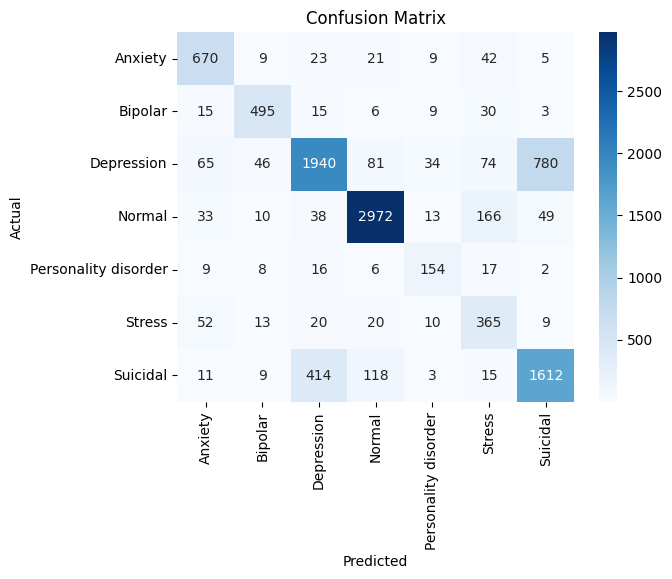

Model, vectorizer, and label encoder saved successfully!
Predicted Status: Stress


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import pickle
import os
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack
from xgboost import XGBClassifier

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv('mental_health_data.csv', index_col=0)

# Data Cleaning
df.dropna(inplace=True)

def remove_patterns(text):
    text = re.sub(r'http[s]?://\S+', '', text)  # Remove URLs
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)  # Remove markdown links
    text = re.sub(r'@\w+', '', text)  # Remove handles
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    return text.strip()

df['statement'] = df['statement'].str.lower().apply(remove_patterns)

# Feature Engineering
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

def stem_tokens(tokens):
    stemmer = PorterStemmer()
    return ' '.join(stemmer.stem(token) for token in tokens)

df['tokens'] = df['statement'].apply(word_tokenize)
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

# Encode labels
lbl_enc = LabelEncoder()
df['status_encoded'] = lbl_enc.fit_transform(df['status'])

# Define features and labels
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status_encoded']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# Combine numerical features with TF-IDF features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

# Oversample the training data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

# Train the XGBoost model
xgb_clf = XGBClassifier(random_state=101)
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Predictions and Evaluation
y_pred_xgb = xgb_clf.predict(X_test_combined)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the trained model, vectorizer, and label encoder
os.makedirs("backend/fastapi/model", exist_ok=True)

with open("backend/fastapi/model/model.pkl", "wb") as f:
    pickle.dump(xgb_clf, f)

with open("backend/fastapi/model/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("backend/fastapi/model/label_encoder.pkl", "wb") as f:
    pickle.dump(lbl_enc, f)

print("Model, vectorizer, and label encoder saved successfully!")

# Preprocessing for new inputs
def preprocess_input(text):
    text = text.lower()
    text = remove_patterns(text)
    tokens = word_tokenize(text)
    stemmed_text = ' '.join(PorterStemmer().stem(token) for token in tokens)
    return stemmed_text

# Predict function
def predict_new_input(input_text):
    processed_text = preprocess_input(input_text)
    processed_tfidf = vectorizer.transform([processed_text])
    num_characters = len(input_text)
    num_sentences = len(nltk.sent_tokenize(input_text))
    numerical_features = np.array([[num_characters, num_sentences]])
    input_combined = hstack([processed_tfidf, numerical_features])
    prediction = xgb_clf.predict(input_combined)
    predicted_status = lbl_enc.inverse_transform(prediction)
    return predicted_status[0]

# Test the prediction function
new_input = "I feel very overwhelmed and stressed out with my work."
print(f"Predicted Status: {predict_new_input(new_input)}")
